In [2]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Data Loading

In [3]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,…,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_responder_0_lagged,feature_responder_1_lagged,feature_responder_2_lagged,feature_responder_3_lagged,feature_responder_4_lagged,feature_responder_5_lagged,feature_responder_6_lagged,feature_responder_7_lagged,feature_responder_8_lagged,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,symbol_id,time_id,weight
i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,f32
0,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,-0.059343,-0.751958,-0.314242,…,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,1,35,3.889038
0,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,-0.059218,-0.298613,0.029315,…,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,1,36,3.889038
0,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,-0.019658,-0.084493,-0.116301,…,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,1,37,3.889038
0,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,0.207732,-0.046667,-0.266864,…,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,1,38,3.889038
0,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.

In [16]:
# we pick responder_6 as the target (same target as the data challenge)
target = "responder_6"
features = [col for col in data.columns if "feature" in col]
X, y = data[features], data[target]

n = X.height
n_train = int(0.8 * n)
X_train_raw = X.slice(0, n_train)
y_train_raw = y.slice(0, n_train)
X_val_raw = X.slice(n_train)
y_val_raw = y.slice(n_train)

# Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# We use .to_numpy() for the scalers
x_train_np = scaler_x.fit_transform(X_train_raw.to_numpy())
# Important: y must be 2D for the scaler
y_train_np = scaler_y.fit_transform(y_train_raw.to_numpy().reshape(-1, 1))

x_val_np = scaler_x.transform(X_val_raw.to_numpy())
y_val_np = scaler_y.transform(y_val_raw.to_numpy().reshape(-1, 1))

# Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, X_np, y_np):
        # We store them as tensors directly to avoid re-converting at each __getitem__
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instantiation
train_dataset = TimeSeriesDataset(x_train_np, y_train_np)
val_dataset = TimeSeriesDataset(x_val_np, y_val_np)

# Loader
train_data_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=0)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=0)

# define model parameters
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]

# optimization parameters
lr = 0.5e-2 
alpha = 0.1
beta = 1.0
n_epochs = 10

# Drop out 

  0%|          | 0/3 [00:00<?, ?it/s]

Training model with dropout 0


Epoch 01 | loss=184.915 | R2_rec_train=0.2095 | R2_rec_val=0.1256 | R2_sup_train=0.7611 | R2_sup_val=0.7917


Epoch 02 | loss=140.130 | R2_rec_train=0.3309 | R2_rec_val=0.1808 | R2_sup_train=0.8261 | R2_sup_val=0.8026


Epoch 03 | loss=135.408 | R2_rec_train=0.3899 | R2_rec_val=0.1967 | R2_sup_train=0.8284 | R2_sup_val=0.8277


Epoch 04 | loss=133.034 | R2_rec_train=0.4206 | R2_rec_val=0.2974 | R2_sup_train=0.8293 | R2_sup_val=0.8409


Epoch 05 | loss=131.396 | R2_rec_train=0.4428 | R2_rec_val=0.3167 | R2_sup_train=0.8299 | R2_sup_val=0.8353


Epoch 06 | loss=129.378 | R2_rec_train=0.4578 | R2_rec_val=0.2627 | R2_sup_train=0.8319 | R2_sup_val=0.8371


Epoch 07 | loss=129.481 | R2_rec_train=0.4532 | R2_rec_val=0.3035 | R2_sup_train=0.8322 | R2_sup_val=0.8266


Epoch 08 | loss=128.150 | R2_rec_train=0.4692 | R2_rec_val=0.2806 | R2_sup_train=0.8328 | R2_sup_val=0.8432


Epoch 09 | loss=128.267 | R2_rec_train=0.4667 | R2_rec_val=0.3614 | R2_sup_train=0.8329 | R2_sup_val=0.8418


100%|██████████| 10/10 [02:42<00:00, 16.21s/it]

Epoch 10 | loss=127.331 | R2_rec_train=0.4794 | R2_rec_val=0.3741 | R2_sup_train=0.8332 | R2_sup_val=0.8446


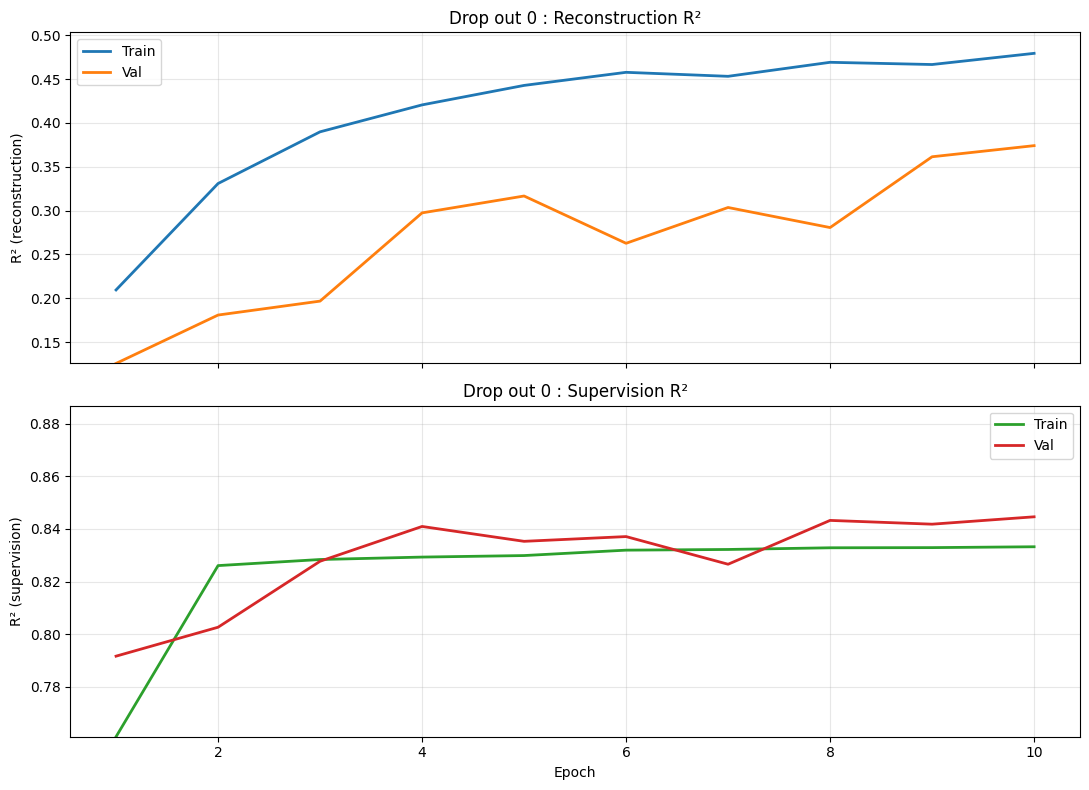

 33%|███▎      | 1/3 [02:42<05:25, 162.70s/it]

Training model with dropout 0.15


Epoch 01 | loss=268.464 | R2_rec_train=0.0917 | R2_rec_val=0.1011 | R2_sup_train=0.6308 | R2_sup_val=0.7645


Epoch 02 | loss=221.063 | R2_rec_train=0.1243 | R2_rec_val=0.1282 | R2_sup_train=0.7074 | R2_sup_val=0.7429


Epoch 03 | loss=217.682 | R2_rec_train=0.1260 | R2_rec_val=0.1281 | R2_sup_train=0.7135 | R2_sup_val=0.7941


Epoch 04 | loss=215.142 | R2_rec_train=0.1328 | R2_rec_val=0.1079 | R2_sup_train=0.7172 | R2_sup_val=0.7707


Epoch 05 | loss=214.619 | R2_rec_train=0.1338 | R2_rec_val=0.1227 | R2_sup_train=0.7180 | R2_sup_val=0.8013


Epoch 06 | loss=213.374 | R2_rec_train=0.1382 | R2_rec_val=0.1363 | R2_sup_train=0.7194 | R2_sup_val=0.7719


Epoch 07 | loss=213.812 | R2_rec_train=0.1454 | R2_rec_val=0.1389 | R2_sup_train=0.7184 | R2_sup_val=0.7905


Epoch 08 | loss=212.373 | R2_rec_train=0.1478 | R2_rec_val=0.1497 | R2_sup_train=0.7201 | R2_sup_val=0.7818


Epoch 09 | loss=212.225 | R2_rec_train=0.1513 | R2_rec_val=0.1254 | R2_sup_train=0.7204 | R2_sup_val=0.7718


100%|██████████| 10/10 [02:46<00:00, 16.66s/it]

Epoch 10 | loss=212.702 | R2_rec_train=0.1517 | R2_rec_val=0.1495 | R2_sup_train=0.7195 | R2_sup_val=0.7604


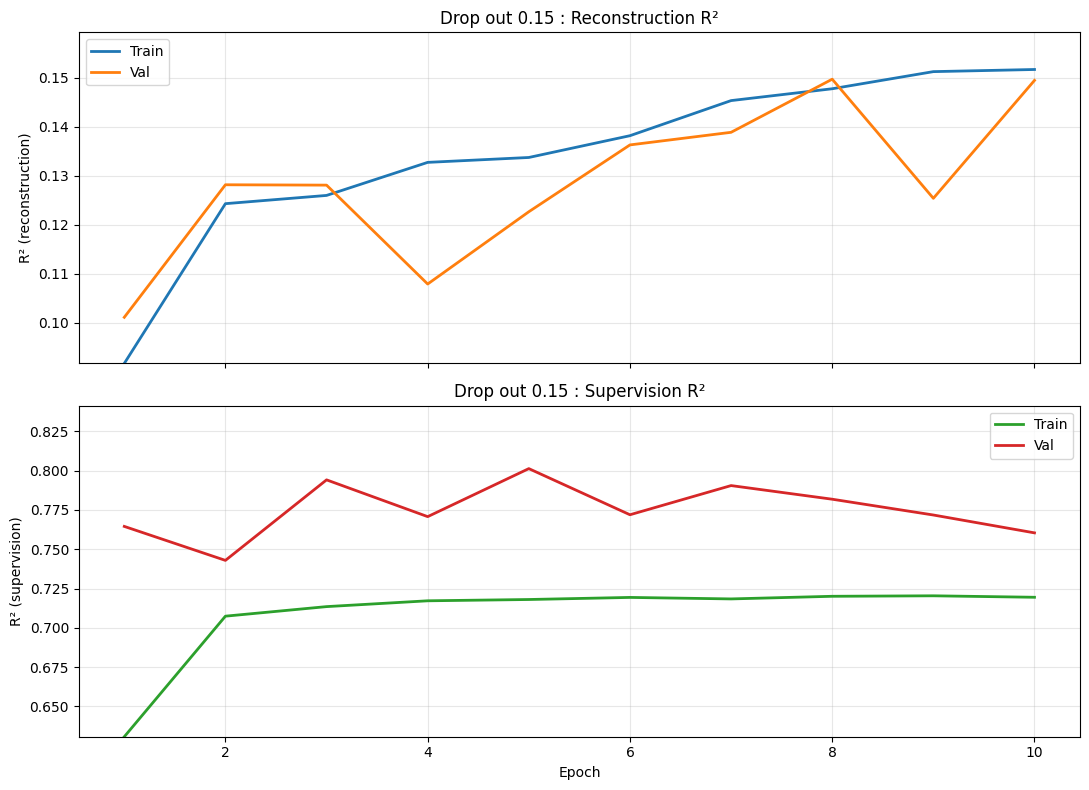

 67%|██████▋   | 2/3 [05:29<02:45, 165.18s/it]

Training model with dropout 0.3


Epoch 01 | loss=398.789 | R2_rec_train=0.0647 | R2_rec_val=0.0911 | R2_sup_train=0.4080 | R2_sup_val=0.5673


Epoch 02 | loss=360.855 | R2_rec_train=0.0832 | R2_rec_val=0.0886 | R2_sup_train=0.4712 | R2_sup_val=0.5671


Epoch 03 | loss=359.592 | R2_rec_train=0.0867 | R2_rec_val=0.0864 | R2_sup_train=0.4734 | R2_sup_val=0.5555


Epoch 04 | loss=358.417 | R2_rec_train=0.0888 | R2_rec_val=0.0937 | R2_sup_train=0.4759 | R2_sup_val=0.5676


Epoch 05 | loss=357.013 | R2_rec_train=0.0907 | R2_rec_val=0.0948 | R2_sup_train=0.4775 | R2_sup_val=0.5863


Epoch 06 | loss=356.207 | R2_rec_train=0.0897 | R2_rec_val=0.1006 | R2_sup_train=0.4786 | R2_sup_val=0.5434


Epoch 07 | loss=356.619 | R2_rec_train=0.0908 | R2_rec_val=0.1015 | R2_sup_train=0.4786 | R2_sup_val=0.5399


Epoch 08 | loss=357.000 | R2_rec_train=0.0898 | R2_rec_val=0.1038 | R2_sup_train=0.4783 | R2_sup_val=0.5475


Epoch 09 | loss=355.465 | R2_rec_train=0.0905 | R2_rec_val=0.0961 | R2_sup_train=0.4799 | R2_sup_val=0.5701


100%|██████████| 10/10 [02:46<00:00, 16.63s/it]

Epoch 10 | loss=356.109 | R2_rec_train=0.0905 | R2_rec_val=0.1012 | R2_sup_train=0.4790 | R2_sup_val=0.5758


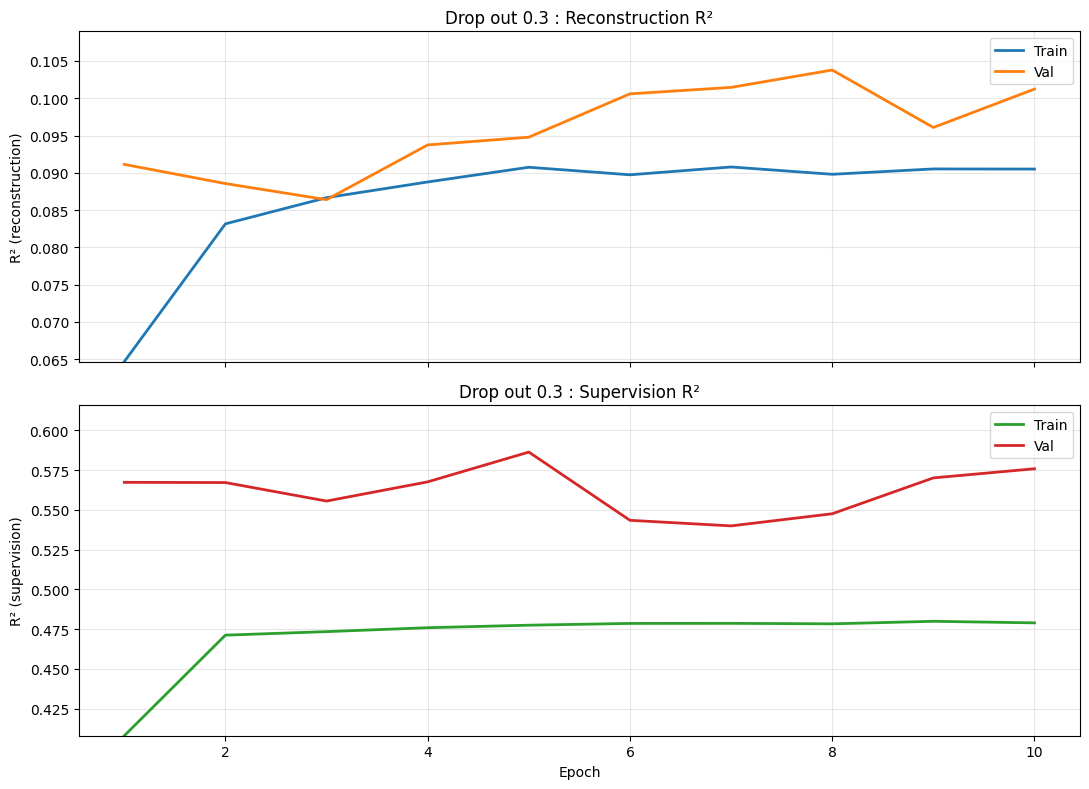

100%|██████████| 3/3 [08:16<00:00, 165.42s/it]


In [17]:
drop_out_values = [0, 0.15, 0.3]
models_drop_out = { p : AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    dropout_p=p
) for p in drop_out_values }

results_drop_out = {}
for p, model in tqdm(models_drop_out.items()):
    print(f"Training model with dropout {p}")
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    results_drop_out[p] = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    title = f"Drop out {p}"
    )

# Batch normalization

  0%|          | 0/2 [00:00<?, ?it/s]

Training model with BN True


Epoch 01 | loss=157.980 | R2_rec_train=0.2665 | R2_rec_val=0.1431 | R2_sup_train=0.8018 | R2_sup_val=0.7872


Epoch 02 | loss=136.433 | R2_rec_train=0.3877 | R2_rec_val=0.1765 | R2_sup_train=0.8267 | R2_sup_val=0.8174


Epoch 03 | loss=132.792 | R2_rec_train=0.4268 | R2_rec_val=0.2452 | R2_sup_train=0.8291 | R2_sup_val=0.8381


Epoch 04 | loss=130.810 | R2_rec_train=0.4452 | R2_rec_val=0.2427 | R2_sup_train=0.8307 | R2_sup_val=0.8453


Epoch 05 | loss=129.071 | R2_rec_train=0.4658 | R2_rec_val=0.3006 | R2_sup_train=0.8316 | R2_sup_val=0.8435


Epoch 06 | loss=128.163 | R2_rec_train=0.4754 | R2_rec_val=0.3220 | R2_sup_train=0.8322 | R2_sup_val=0.8463


Epoch 07 | loss=127.376 | R2_rec_train=0.4827 | R2_rec_val=0.2991 | R2_sup_train=0.8330 | R2_sup_val=0.8477


Epoch 08 | loss=126.787 | R2_rec_train=0.4873 | R2_rec_val=0.3603 | R2_sup_train=0.8334 | R2_sup_val=0.8502


Epoch 09 | loss=126.212 | R2_rec_train=0.4926 | R2_rec_val=0.3377 | R2_sup_train=0.8339 | R2_sup_val=0.8499


100%|██████████| 10/10 [02:58<00:00, 17.86s/it]

Epoch 10 | loss=126.065 | R2_rec_train=0.4937 | R2_rec_val=0.3538 | R2_sup_train=0.8342 | R2_sup_val=0.8391


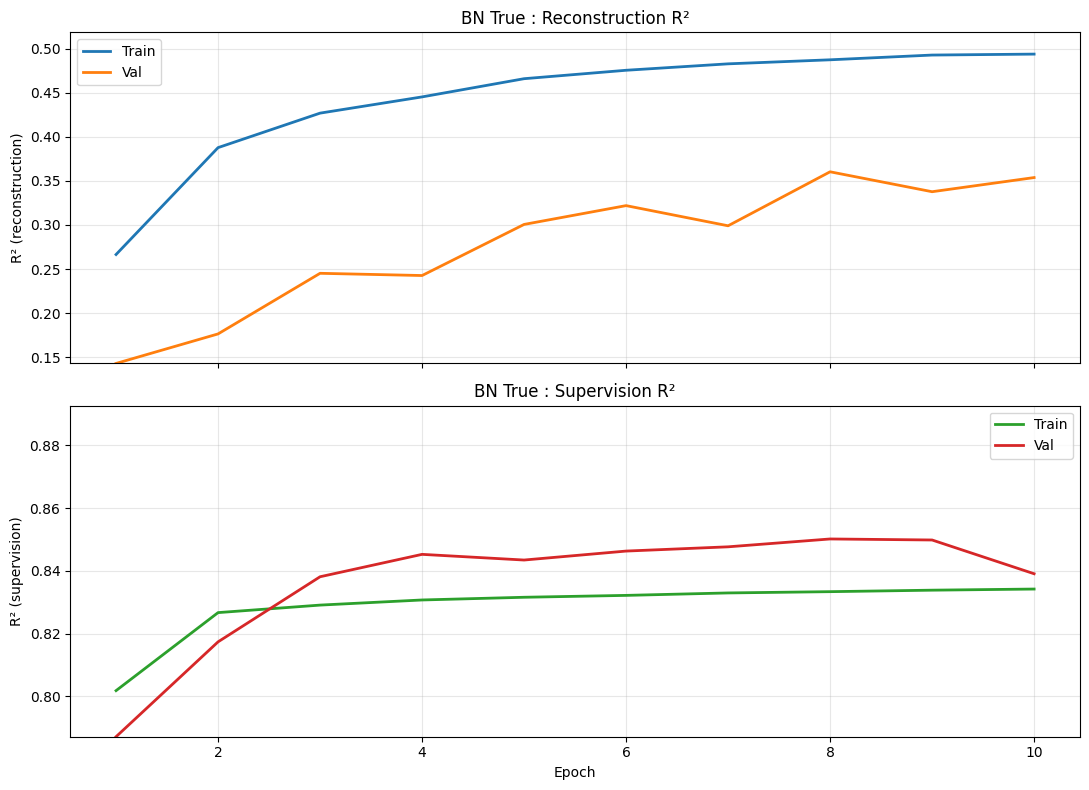

 50%|█████     | 1/2 [02:58<02:58, 178.95s/it]

Training model with BN False


Epoch 01 | loss=168.529 | R2_rec_train=0.2044 | R2_rec_val=-0.3170 | R2_sup_train=0.7924 | R2_sup_val=0.6891


Epoch 02 | loss=145.971 | R2_rec_train=0.2715 | R2_rec_val=0.1631 | R2_sup_train=0.8220 | R2_sup_val=0.8017


Epoch 03 | loss=136.404 | R2_rec_train=0.3604 | R2_rec_val=0.2077 | R2_sup_train=0.8295 | R2_sup_val=0.8272


Epoch 04 | loss=133.191 | R2_rec_train=0.4058 | R2_rec_val=0.2467 | R2_sup_train=0.8306 | R2_sup_val=0.8275


Epoch 05 | loss=131.705 | R2_rec_train=0.4285 | R2_rec_val=0.3105 | R2_sup_train=0.8310 | R2_sup_val=0.8360


Epoch 06 | loss=130.243 | R2_rec_train=0.4457 | R2_rec_val=0.3257 | R2_sup_train=0.8317 | R2_sup_val=0.8432


Epoch 07 | loss=129.084 | R2_rec_train=0.4554 | R2_rec_val=0.2487 | R2_sup_train=0.8325 | R2_sup_val=0.8414


Epoch 08 | loss=129.215 | R2_rec_train=0.4524 | R2_rec_val=0.1656 | R2_sup_train=0.8328 | R2_sup_val=0.8332


Epoch 09 | loss=131.044 | R2_rec_train=0.4197 | R2_rec_val=0.2889 | R2_sup_train=0.8327 | R2_sup_val=0.8443


100%|██████████| 10/10 [02:46<00:00, 16.67s/it]

Epoch 10 | loss=128.116 | R2_rec_train=0.4638 | R2_rec_val=0.3314 | R2_sup_train=0.8334 | R2_sup_val=0.8477


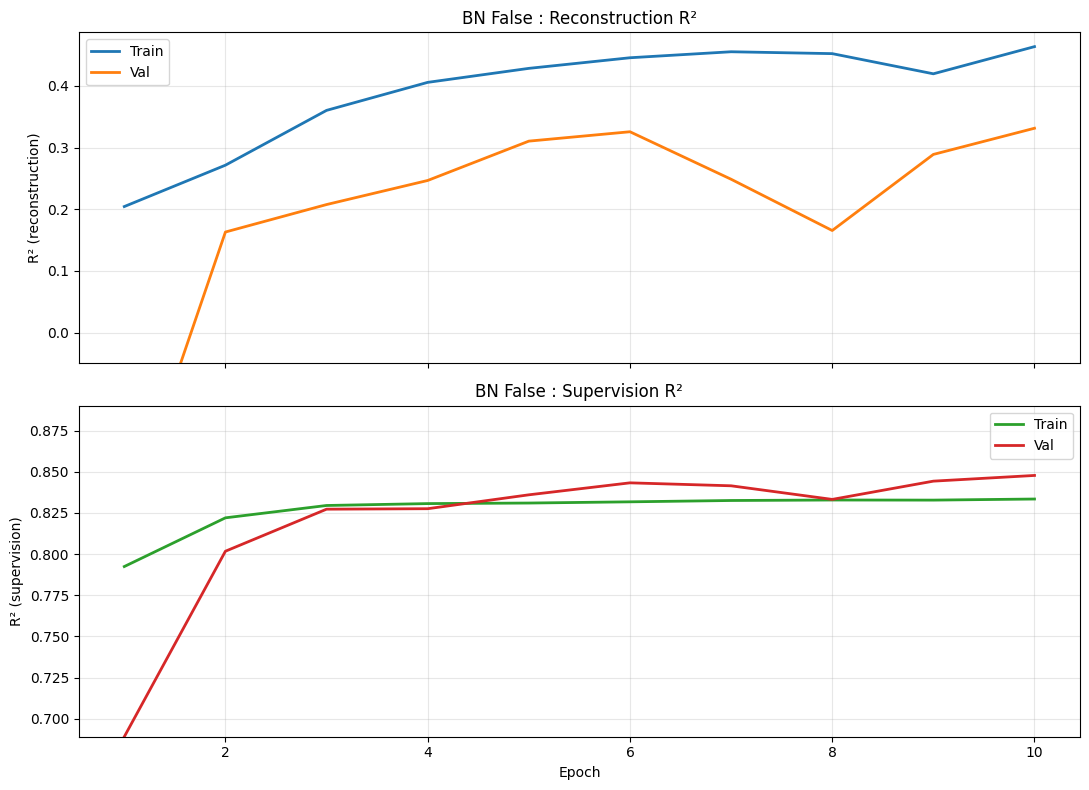

100%|██████████| 2/2 [05:46<00:00, 173.00s/it]


In [19]:
bn_values = {"True":True, "False":False}
models_bn = { k : AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    use_bn=v 
) for k, v in  bn_values.items()}

results_bn = {}
for p, model in tqdm(models_bn.items()):
    print(f"Training model with BN {p}")
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    results_bn[p] = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    title=f"BN {p}"
    )

# Activation

  0%|          | 0/3 [00:00<?, ?it/s]

Training model with activation ReLU


Epoch 01 | loss=241.451 | R2_rec_train=0.2362 | R2_rec_val=0.2057 | R2_sup_train=0.6612 | R2_sup_val=0.7757


Epoch 02 | loss=161.557 | R2_rec_train=0.3720 | R2_rec_val=0.2593 | R2_sup_train=0.7853 | R2_sup_val=0.7732


Epoch 03 | loss=147.628 | R2_rec_train=0.4235 | R2_rec_val=0.3064 | R2_sup_train=0.8041 | R2_sup_val=0.7570


Epoch 04 | loss=141.650 | R2_rec_train=0.4458 | R2_rec_val=0.3334 | R2_sup_train=0.8120 | R2_sup_val=0.8039


Epoch 05 | loss=138.115 | R2_rec_train=0.4536 | R2_rec_val=0.3202 | R2_sup_train=0.8172 | R2_sup_val=0.8299


Epoch 06 | loss=134.931 | R2_rec_train=0.4702 | R2_rec_val=0.3591 | R2_sup_train=0.8211 | R2_sup_val=0.8356


Epoch 07 | loss=133.063 | R2_rec_train=0.4781 | R2_rec_val=0.3189 | R2_sup_train=0.8237 | R2_sup_val=0.8391


Epoch 08 | loss=131.501 | R2_rec_train=0.4836 | R2_rec_val=0.3687 | R2_sup_train=0.8257 | R2_sup_val=0.7966


Epoch 09 | loss=130.968 | R2_rec_train=0.4866 | R2_rec_val=0.3242 | R2_sup_train=0.8262 | R2_sup_val=0.8295


100%|██████████| 10/10 [02:43<00:00, 16.36s/it]

Epoch 10 | loss=129.266 | R2_rec_train=0.4967 | R2_rec_val=0.3750 | R2_sup_train=0.8283 | R2_sup_val=0.8280


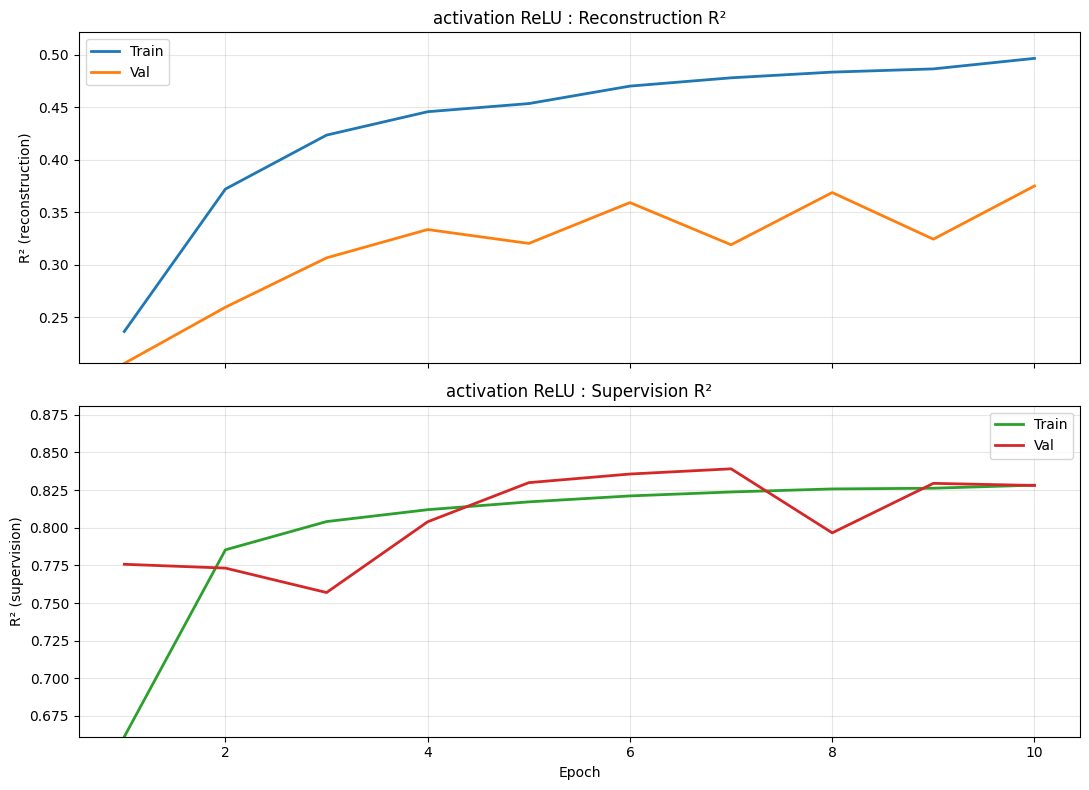

 33%|███▎      | 1/3 [02:43<05:27, 163.94s/it]

Training model with activation SiLU


Epoch 01 | loss=211.474 | R2_rec_train=0.2097 | R2_rec_val=0.1966 | R2_sup_train=0.7155 | R2_sup_val=0.7953


Epoch 02 | loss=149.953 | R2_rec_train=0.3500 | R2_rec_val=0.2059 | R2_sup_train=0.8074 | R2_sup_val=0.8189


Epoch 03 | loss=141.129 | R2_rec_train=0.3880 | R2_rec_val=0.2397 | R2_sup_train=0.8186 | R2_sup_val=0.8324


Epoch 04 | loss=136.525 | R2_rec_train=0.4113 | R2_rec_val=0.2326 | R2_sup_train=0.8243 | R2_sup_val=0.8335


Epoch 05 | loss=133.325 | R2_rec_train=0.4331 | R2_rec_val=0.3082 | R2_sup_train=0.8275 | R2_sup_val=0.8421


Epoch 06 | loss=130.840 | R2_rec_train=0.4515 | R2_rec_val=0.3260 | R2_sup_train=0.8299 | R2_sup_val=0.8440


Epoch 07 | loss=129.933 | R2_rec_train=0.4601 | R2_rec_val=0.2979 | R2_sup_train=0.8306 | R2_sup_val=0.8430


Epoch 08 | loss=129.866 | R2_rec_train=0.4571 | R2_rec_val=0.3076 | R2_sup_train=0.8313 | R2_sup_val=0.8266


Epoch 09 | loss=129.153 | R2_rec_train=0.4596 | R2_rec_val=0.3497 | R2_sup_train=0.8320 | R2_sup_val=0.8447


100%|██████████| 10/10 [02:43<00:00, 16.31s/it]

Epoch 10 | loss=127.690 | R2_rec_train=0.4740 | R2_rec_val=0.2876 | R2_sup_train=0.8335 | R2_sup_val=0.8413


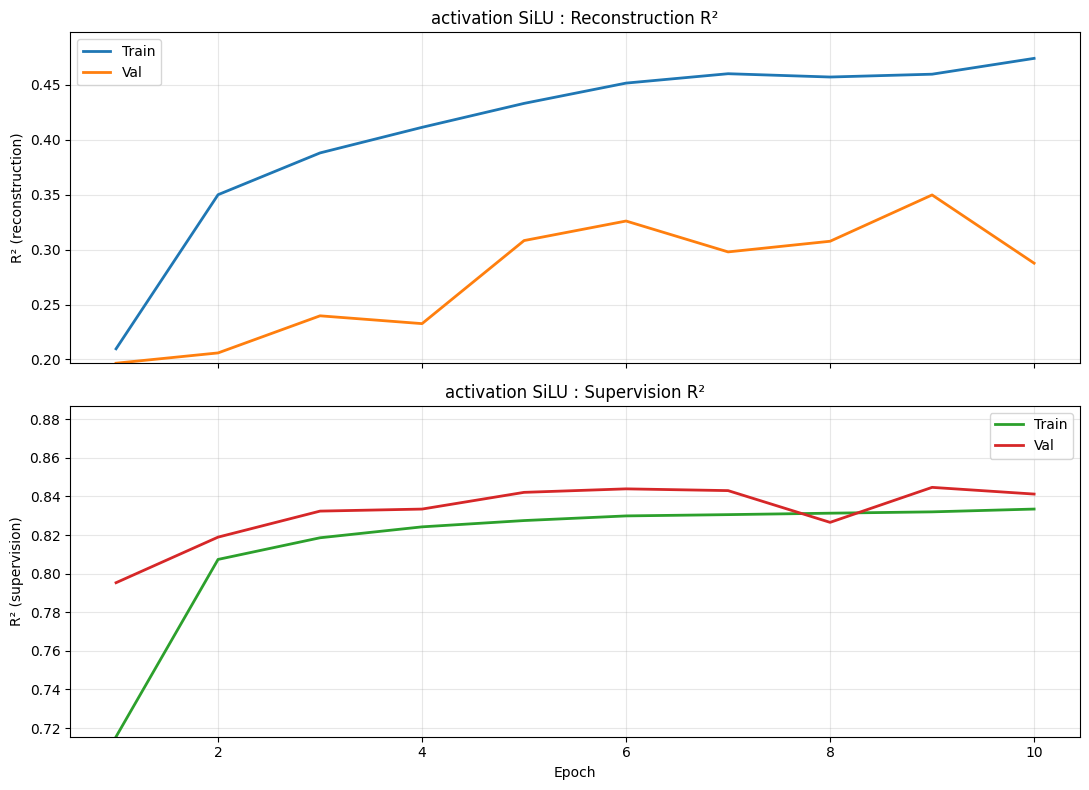

 67%|██████▋   | 2/3 [05:27<02:43, 163.65s/it]

Training model with activation LeakyReLU


Epoch 01 | loss=171.372 | R2_rec_train=0.2139 | R2_rec_val=0.1983 | R2_sup_train=0.7840 | R2_sup_val=0.7941


Epoch 02 | loss=138.773 | R2_rec_train=0.3512 | R2_rec_val=0.1733 | R2_sup_train=0.8264 | R2_sup_val=0.8167


Epoch 03 | loss=134.200 | R2_rec_train=0.4015 | R2_rec_val=0.2548 | R2_sup_train=0.8292 | R2_sup_val=0.8249


Epoch 04 | loss=131.558 | R2_rec_train=0.4363 | R2_rec_val=0.2929 | R2_sup_train=0.8303 | R2_sup_val=0.8408


Epoch 05 | loss=128.806 | R2_rec_train=0.4664 | R2_rec_val=0.3072 | R2_sup_train=0.8320 | R2_sup_val=0.8438


Epoch 06 | loss=127.713 | R2_rec_train=0.4828 | R2_rec_val=0.2738 | R2_sup_train=0.8323 | R2_sup_val=0.8421


Epoch 07 | loss=126.781 | R2_rec_train=0.4913 | R2_rec_val=0.3108 | R2_sup_train=0.8330 | R2_sup_val=0.8460


Epoch 08 | loss=127.189 | R2_rec_train=0.4794 | R2_rec_val=0.3251 | R2_sup_train=0.8334 | R2_sup_val=0.8425


Epoch 09 | loss=126.156 | R2_rec_train=0.4965 | R2_rec_val=0.3666 | R2_sup_train=0.8337 | R2_sup_val=0.8458


100%|██████████| 10/10 [02:44<00:00, 16.49s/it]

Epoch 10 | loss=125.637 | R2_rec_train=0.5010 | R2_rec_val=0.3456 | R2_sup_train=0.8340 | R2_sup_val=0.8438


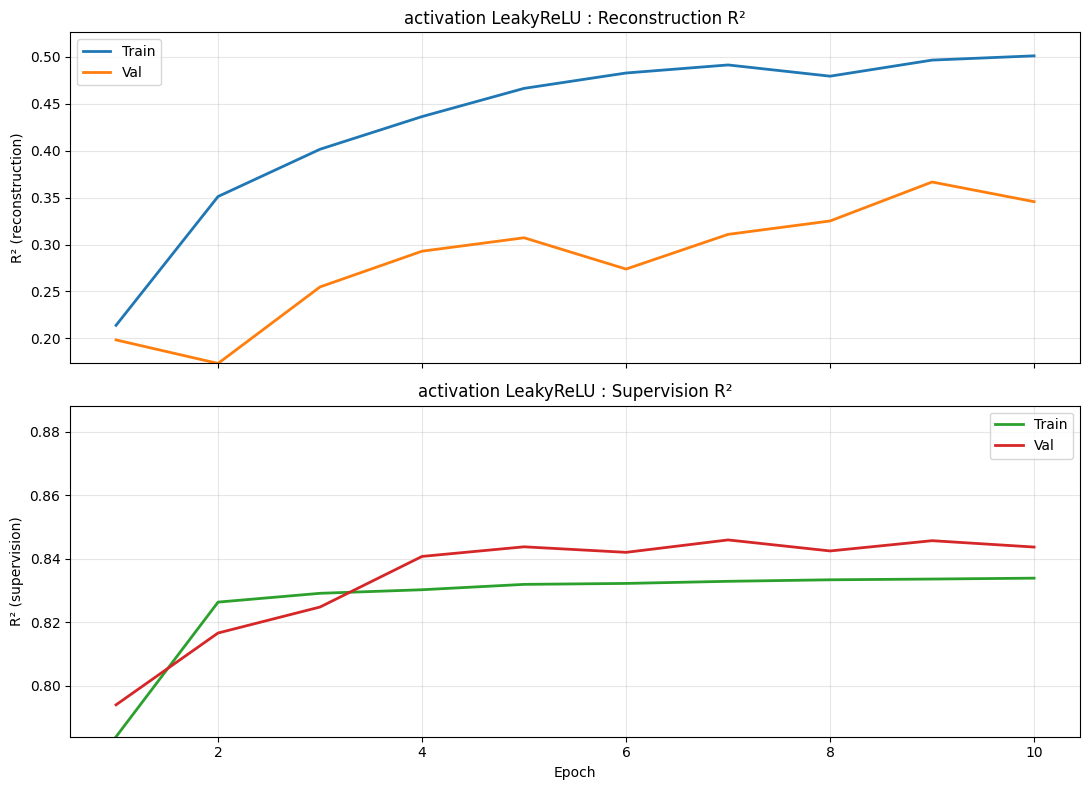

100%|██████████| 3/3 [08:12<00:00, 164.19s/it]


In [20]:
activation_values = {"ReLU":torch.nn.ReLU, "SiLU":torch.nn.SiLU, "LeakyReLU":torch.nn.LeakyReLU}
models_activation = { k : AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    activation=v 
) for k, v in  activation_values.items()}

results_activation = {}
for p, model in tqdm(models_activation.items()):
    print(f"Training model with activation {p}")
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    results_activation[p] = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    title=f"activation {p}"
    )